In [1]:
import numpy as np
import pandas as pd
from astropy.table import Table, Column
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.io import fits
from scipy.interpolate import interp1d
plt.rcParams['figure.figsize'] = [9, 6]
plt.rcParams["font.family"] = "serif"
plt.rcParams['text.usetex'] = False
%matplotlib inline

In [2]:
#read the catalog
#COSMOS2015 = fits.open('COSMOS2015_Laigle+_v2.1.fits')
COSMOS2015 = fits.open('COSMOS2015_Laigle+_v2.1.fits')
#print(COSMOS2015[1].data.names)

In [3]:
#makes the basic cuts
mask_basic = (COSMOS2015[1].data['MASS_MED'] > 8) & (COSMOS2015[1].data['MASS_MED'] < 9)
mask_basic *= COSMOS2015[1].data['TYPE'] == 0
mask_basic *= COSMOS2015[1].data['FLAG_HJMCC'] == 0
mask_basic *= COSMOS2015[1].data['FLAG_PETER'] == 0
mask_basic *= COSMOS2015[1].data['FLAG_COSMOS'] == 1

In [4]:
#plt.scatter(COSMOS2015[1].data[mask_basic]['ALPHA_J2000'],COSMOS2015[1].data[mask_basic]['DELTA_J2000'],s=0.01)

In [5]:
#sample 1
mask_sample1 = mask_basic * (COSMOS2015[1].data['redshift'] > 0.0001) & (COSMOS2015[1].data['redshift'] < 0.15)
sample1 = COSMOS2015[1].data[mask_sample1]
print(len(sample1),'galaxies')
#sample for IA709
z_min_IA709 = (7082-318/2)/6564-1
z_max_IA709 = (7082+318/2)/6564-1
mask_IA709 = mask_basic * (COSMOS2015[1].data['redshift'] > z_min_IA709) & (COSMOS2015[1].data['redshift'] < z_max_IA709)
sample_IA709 = COSMOS2015[1].data[mask_IA709]
print(len(sample_IA709),'galaxies')

940 galaxies
277 galaxies


sample 1 = 940 galaxies
sample1_goodz = 377 galaxies
sample_IA709 = 277 galaxies
z_min_IA709 = 0.05469226081657519
z_max_IA709 = 0.10313833028641062


Text(0.5,0,'r_mag_auto')

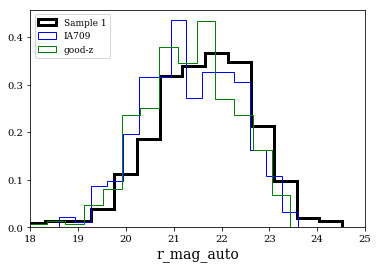

In [6]:
#sample 1
mask_sample1 = mask_basic * (COSMOS2015[1].data['redshift'] > 0.0001) & (COSMOS2015[1].data['redshift'] < 0.15)
sample1 = COSMOS2015[1].data[mask_sample1]
print('sample 1 =', len(sample1),'galaxies')
#good z
mask_goodz = mask_sample1 * COSMOS2015[1].data['good_z']
sample_goodz = COSMOS2015[1].data[mask_goodz]
print('sample1_goodz =', len(sample_goodz),'galaxies')
#sample for IA709
z_min_IA709 = (7082-318/2)/6564-1
z_max_IA709 = (7082+318/2)/6564-1
mask_IA709 = mask_basic * (COSMOS2015[1].data['redshift'] > z_min_IA709) & (COSMOS2015[1].data['redshift'] < z_max_IA709)
sample_IA709 = COSMOS2015[1].data[mask_IA709]
print('sample_IA709 =', len(sample_IA709),'galaxies')
print('z_min_IA709 =',z_min_IA709)
print('z_max_IA709 =',z_max_IA709)
plt.hist(sample1['r_MAG_AUTO'],bins=15,histtype='step',linewidth=3,density=True,stacked=True,color='k',label='Sample 1')
plt.hist(sample_IA709['r_MAG_AUTO'],bins=15,histtype='step',linewidth=1,density=True,stacked=True,color='b',label='IA709')
plt.hist(sample_goodz['r_MAG_AUTO'],bins=15,histtype='step',linewidth=1,density=True,stacked=True,color='g',label='good-z')
plt.legend(loc='upper left',fontsize=9)
plt.xlim(18,25)
plt.xlabel('r_mag_auto',fontsize=14)
#plt.ylabel('',fontsize=14)
#plt.savefig('mag_hist_new.eps',dpi=300)

In [7]:
mask_sample1 = mask_basic * (COSMOS2015[1].data['redshift'] > 0.0001) & (COSMOS2015[1].data['redshift'] < 0.15)
sample1 = COSMOS2015[1].data[mask_sample1]

mask_sample2 = mask_basic * (COSMOS2015[1].data['redshift'] > 0.0001) & (COSMOS2015[1].data['redshift'] < 0.3)
sample2 = COSMOS2015[1].data[mask_sample2]

940
5123


(-0.5, 3.5)

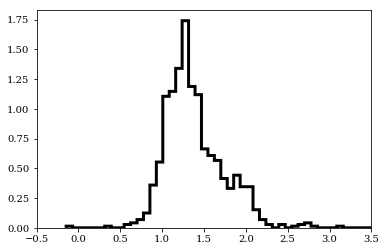

In [8]:
ui_sample1 = sample1['u_MAG_AUTO']-sample1['r_MAG_AUTO']
ui_sample2 = sample2['u_MAG_AUTO']-sample2['r_MAG_AUTO']

plt.hist(ui_sample1,bins=1000,histtype='step',linewidth=3,density=True,stacked=True,color='k',label='Sample 1')
#plt.hist(ui_sample2,bins=1000,histtype='step',linewidth=3,density=True,stacked=True,color='r',label='Sample 1')
print(len(ui_sample1))
print(len(ui_sample2))
#plt.legend(loc='upper left',fontsize=9)
plt.xlim(-0.5,3.5)
#plt.xlabel('r_mag_auto',fontsize=14)
#plt.ylabel('',fontsize=14)
#plt.savefig('mag_hist_new.eps',dpi=300)

In [9]:
line_wavelengths = {
    # approximate! I'm not an expert at knowing exactly
    # which transitions people mean
    # main source: http://www.astrosurf.com/buil/filters/curves.htm
    "H_beta" : 486.1,
    "O_III": 500.7,
    "H_alpha" : 656.3,
    "S_II" : 673.0,
#   "O_II" : 687, # where did I get this?
}

In [10]:
mask_IA709 = mask_basic * (COSMOS2015[1].data['r_MAG_AUTO'] < 24) * (COSMOS2015[1].data['IB709_MAG_AUTO'] < 25)
mask_IA709 *= (COSMOS2015[1].data['redshift'] > 0.0001) & (COSMOS2015[1].data['redshift'] < 0.2)
sample_IA709 = COSMOS2015[1].data[mask_IA709]
print(len(sample_IA709),'galaxies')

1775 galaxies


In [ ]:
#sample_IA709.dtype.names

In [11]:
def galaxy_detect_narrowband(galaxy,filter_name):
    mag427 = pow(10,-0.4*sample_IA709['IB427_MAG_AUTO'][galaxy])
    mag464 = pow(10,-0.4*sample_IA709['IB464_MAG_AUTO'][galaxy])
    mag484 = pow(10,-0.4*sample_IA709['IA484_MAG_AUTO'][galaxy])
    mag505 = pow(10,-0.4*sample_IA709['IB505_MAG_AUTO'][galaxy])
    mag527 = pow(10,-0.4*sample_IA709['IA527_MAG_AUTO'][galaxy])
    mag574 = pow(10,-0.4*sample_IA709['IB574_MAG_AUTO'][galaxy])
    mag624 = pow(10,-0.4*sample_IA709['IA624_MAG_AUTO'][galaxy])
    mag679 = pow(10,-0.4*sample_IA709['IA679_MAG_AUTO'][galaxy])
    mag709 = pow(10,-0.4*sample_IA709['IB709_MAG_AUTO'][galaxy])
    mag738 = pow(10,-0.4*sample_IA709['IA738_MAG_AUTO'][galaxy])
    mag767 = pow(10,-0.4*sample_IA709['IA767_MAG_AUTO'][galaxy])
    mag827 = pow(10,-0.4*sample_IA709['IB827_MAG_AUTO'][galaxy])
    redshift = sample_IA709['redshift'][galaxy]
    wave_cont = np.array([427,464,484,574,624,767,827])#/(1+redshift)
    flux_cont = np.array([mag427,mag464,mag484,mag574,mag624,mag767,mag827])*10**9
    SED_func_cont = interp1d(wave_cont, flux_cont, kind=1)
    x_wave_cont = np.linspace(np.min(wave_cont),np.max(wave_cont),100000)
    SED_interp1d_cont = SED_func_cont(x_wave_cont)

    wave = np.array([427,464,484,505,527,574,624,679,709,738,767,827])#/(1+redshift)
    flux = np.array([mag427,mag464,mag484,mag505,mag527,mag574,mag624,mag679,mag709,mag738,mag767,mag827])*10**9
    SED_func = interp1d(wave, flux, kind=1)
    x_wave = np.linspace(np.min(wave),np.max(wave),100000)
    SED_interp1d = SED_func(x_wave)
    line_over_cont = round(mag709*10**9-SED_func_cont(709),5)
    real_redshift = round(sample_IA709['redshift'][galaxy],5)
    
    #plt.plot(x_wave,SED_interp1d,c='y')
    #plt.plot(x_wave_cont,SED_interp1d_cont,c='orange')
    #plt.scatter(wave,flux,c='k')
    #plt.scatter(709,mag709*10**9,c='r',s=100)
    #plt.axvline(x=486.1*(1+redshift),c='b')
    #plt.axvline(x=500.7*(1+redshift),c='g')
    #plt.axvline(x=656.3*(1+redshift),c='r')
    #plt.axvline(x=673.0*(1+redshift),c='k')
        
    return line_over_cont, real_redshift

In [ ]:
# a nice example
galaxy = 994
filter_name = 'IA709'
line_over_cont,real_redshift = galaxy_detect_narrowband(galaxy,filter_name)
print(line_over_cont)

In [12]:
galaxy_detected_narrowband = []
galaxy_real_detected_narrowband = []
galaxy_real_notdetected_narrowband = []

galaxy = 0
while galaxy < len(sample_IA709['IB709_MAG_AUTO']):
    filter_name = 'IA709'
    line_over_cont,real_redshift = galaxy_detect_narrowband(galaxy,filter_name)
    
    if line_over_cont > 0.0:
        detected = True
        galaxy_detected_narrowband.append(detected)
        if real_redshift > z_min_IA709 and real_redshift < z_max_IA709:
            detected_real = True
            print(galaxy,'******','detected','line_over_cont =',line_over_cont,'redshift =',real_redshift,'******')
            galaxy_real_detected_narrowband.append(detected_real)
        else:
            detected_real = False
            print(galaxy,'detected(not real)','line_over_cont =',line_over_cont,'redshift =',real_redshift)
            galaxy_real_detected_narrowband.append(detected_real)
    else:
        detected = False
        galaxy_detected_narrowband.append(detected)
        print(galaxy,'none','line_over_cont =',line_over_cont,'redshift =',real_redshift)
        if real_redshift > z_min_IA709 and real_redshift < z_max_IA709:
            notdetected_real = True
            galaxy_real_notdetected_narrowband.append(notdetected_real)
        else:
            notdetected_real = False
            galaxy_real_notdetected_narrowband.append(notdetected_real)

    galaxy = galaxy + 1

0 none line_over_cont = -0.07795 redshift = 0.1315
1 none line_over_cont = -0.04125 redshift = 0.1908
2 none line_over_cont = -0.05384 redshift = 0.1398
3 none line_over_cont = -0.02531 redshift = 0.1753
4 ****** detected line_over_cont = 1.63161 redshift = 0.07 ******
5 none line_over_cont = -0.02691 redshift = 0.1986
6 none line_over_cont = -0.30522 redshift = 0.1701
7 none line_over_cont = -0.01166 redshift = 0.1913
8 none line_over_cont = -0.00714 redshift = 0.1922
9 none line_over_cont = -0.08457 redshift = 0.1398
10 none line_over_cont = -0.03384 redshift = 0.1514
11 detected(not real) line_over_cont = 0.18974 redshift = 0.11
12 detected(not real) line_over_cont = 0.2385 redshift = 0.1875
13 ****** detected line_over_cont = 0.60983 redshift = 0.0897 ******
14 none line_over_cont = -0.10038 redshift = 0.1887
15 none line_over_cont = -0.12324 redshift = 0.1704
16 none line_over_cont = -0.69771 redshift = 0.19
17 detected(not real) line_over_cont = 0.20576 redshift = 0.1312
18 detec

178 ****** detected line_over_cont = 0.24532 redshift = 0.1 ******
179 detected(not real) line_over_cont = 0.00342 redshift = 0.1982
180 ****** detected line_over_cont = 0.19109 redshift = 0.0898 ******
181 none line_over_cont = -0.76231 redshift = 0.1743
182 detected(not real) line_over_cont = 0.84767 redshift = 0.005
183 detected(not real) line_over_cont = 0.03375 redshift = 0.14
184 none line_over_cont = -0.18962 redshift = 0.1661
185 none line_over_cont = -0.07159 redshift = 0.1852
186 none line_over_cont = -0.05625 redshift = 0.13
187 none line_over_cont = -1.17715 redshift = 0.0795
188 none line_over_cont = -0.12535 redshift = 0.12378
189 detected(not real) line_over_cont = 0.92671 redshift = 0.1388
190 none line_over_cont = -0.06223 redshift = 0.1353
191 detected(not real) line_over_cont = 0.01374 redshift = 0.1114
192 none line_over_cont = -0.03351 redshift = 0.1105
193 none line_over_cont = -0.01508 redshift = 0.1127
194 detected(not real) line_over_cont = 0.00537 redshift = 0

325 ****** detected line_over_cont = 1.67124 redshift = 0.0671 ******
326 none line_over_cont = -0.00462 redshift = 0.1115
327 none line_over_cont = -0.09827 redshift = 0.1219
328 ****** detected line_over_cont = 0.08376 redshift = 0.0997 ******
329 detected(not real) line_over_cont = 0.11115 redshift = 0.1158
330 ****** detected line_over_cont = 0.03181 redshift = 0.1018 ******
331 none line_over_cont = -0.022 redshift = 0.1708
332 none line_over_cont = -0.02029 redshift = 0.1586
333 detected(not real) line_over_cont = 0.15049 redshift = 0.14
334 none line_over_cont = -0.2393 redshift = 0.1399
335 none line_over_cont = -0.05585 redshift = 0.0975
336 none line_over_cont = -0.03366 redshift = 0.1498
337 none line_over_cont = -0.01121 redshift = 0.14
338 detected(not real) line_over_cont = 0.06191 redshift = 0.1343
339 none line_over_cont = -0.12376 redshift = 0.1243
340 ****** detected line_over_cont = 1.86597 redshift = 0.1 ******
341 none line_over_cont = -0.07088 redshift = 0.1328
34

470 none line_over_cont = -0.07798 redshift = 0.1136
471 detected(not real) line_over_cont = 0.01069 redshift = 0.1723
472 none line_over_cont = -0.01261 redshift = 0.1984
473 none line_over_cont = -0.02658 redshift = 0.1781
474 none line_over_cont = -0.10087 redshift = 0.1252
475 ****** detected line_over_cont = 0.45631 redshift = 0.0993 ******
476 none line_over_cont = -0.14903 redshift = 0.1008
477 none line_over_cont = -0.01136 redshift = 0.1783
478 none line_over_cont = -0.09353 redshift = 0.1751
479 none line_over_cont = -0.21354 redshift = 0.17309
480 detected(not real) line_over_cont = 0.01988 redshift = 0.1485
481 detected(not real) line_over_cont = 0.0131 redshift = 0.1849
482 none line_over_cont = -0.10235 redshift = 0.1772
483 none line_over_cont = -0.14469 redshift = 0.1589
484 none line_over_cont = -0.04794 redshift = 0.1554
485 none line_over_cont = -0.04395 redshift = 0.1239
486 ****** detected line_over_cont = 0.53115 redshift = 0.08585 ******
487 none line_over_cont =

613 none line_over_cont = -0.00171 redshift = 0.1794
614 none line_over_cont = -0.28913 redshift = 0.1601
615 detected(not real) line_over_cont = 0.00613 redshift = 0.1242
616 none line_over_cont = -0.15711 redshift = 0.1851
617 none line_over_cont = -0.26133 redshift = 0.1548
618 none line_over_cont = -0.04814 redshift = 0.1851
619 ****** detected line_over_cont = 0.05112 redshift = 0.1004 ******
620 none line_over_cont = -0.076 redshift = 0.17153
621 none line_over_cont = -0.06989 redshift = 0.1393
622 none line_over_cont = -0.07688 redshift = 0.186
623 detected(not real) line_over_cont = 0.00337 redshift = 0.1311
624 ****** detected line_over_cont = 0.35605 redshift = 0.0884 ******
625 none line_over_cont = -0.14576 redshift = 0.1883
626 ****** detected line_over_cont = 0.12061 redshift = 0.0956 ******
627 none line_over_cont = -0.34584 redshift = 0.1899
628 detected(not real) line_over_cont = 0.01757 redshift = 0.1971
629 detected(not real) line_over_cont = 0.03936 redshift = 0.195

759 none line_over_cont = -0.21326 redshift = 0.1876
760 none line_over_cont = -0.12878 redshift = 0.1305
761 none line_over_cont = -0.0291 redshift = 0.1739
762 ****** detected line_over_cont = 0.11733 redshift = 0.1009 ******
763 none line_over_cont = -0.12033 redshift = 0.1674
764 none line_over_cont = -0.17691 redshift = 0.1399
765 none line_over_cont = -0.12512 redshift = 0.1311
766 none line_over_cont = -0.02738 redshift = 0.1357
767 none line_over_cont = -0.11552 redshift = 0.1241
768 none line_over_cont = -0.09138 redshift = 0.1852
769 none line_over_cont = -0.29202 redshift = 0.13459
770 none line_over_cont = -0.0621 redshift = 0.16807
771 none line_over_cont = -0.041 redshift = 0.1885
772 detected(not real) line_over_cont = 0.66297 redshift = 0.1649
773 detected(not real) line_over_cont = 0.00737 redshift = 0.1725
774 none line_over_cont = -0.08068 redshift = 0.1222
775 detected(not real) line_over_cont = 0.02538 redshift = 0.1189
776 none line_over_cont = -0.06166 redshift =

902 none line_over_cont = -0.13013 redshift = 0.1668
903 detected(not real) line_over_cont = 0.01184 redshift = 0.1713
904 detected(not real) line_over_cont = 0.01076 redshift = 0.1399
905 none line_over_cont = -0.01394 redshift = 0.1132
906 none line_over_cont = -0.07646 redshift = 0.1061
907 detected(not real) line_over_cont = 2.8204 redshift = 0.02662
908 none line_over_cont = -0.07719 redshift = 0.1537
909 none line_over_cont = -0.11496 redshift = 0.1385
910 none line_over_cont = -0.03463 redshift = 0.1022
911 none line_over_cont = -0.09063 redshift = 0.18838
912 detected(not real) line_over_cont = 0.03286 redshift = 0.1061
913 none line_over_cont = -0.22152 redshift = 0.169
914 detected(not real) line_over_cont = 0.00299 redshift = 0.11639
915 detected(not real) line_over_cont = 0.00982 redshift = 0.1397
916 none line_over_cont = -0.11065 redshift = 0.1808
917 none line_over_cont = -0.25461 redshift = 0.1397
918 detected(not real) line_over_cont = 0.02325 redshift = 0.12599
919 de

1046 none line_over_cont = -0.04664 redshift = 0.1983
1047 none line_over_cont = -0.1937 redshift = 0.1769
1048 ****** detected line_over_cont = 0.76272 redshift = 0.0923 ******
1049 none line_over_cont = -0.03048 redshift = 0.0686
1050 none line_over_cont = -0.19924 redshift = 0.1874
1051 none line_over_cont = -0.18066 redshift = 0.1529
1052 none line_over_cont = -0.07517 redshift = 0.1988
1053 detected(not real) line_over_cont = 0.01659 redshift = 0.1063
1054 detected(not real) line_over_cont = 0.01798 redshift = 0.1779
1055 detected(not real) line_over_cont = 0.00973 redshift = 0.1398
1056 none line_over_cont = -0.00182 redshift = 0.1964
1057 none line_over_cont = -0.3971 redshift = 0.1698
1058 none line_over_cont = -0.77794 redshift = 0.1576
1059 detected(not real) line_over_cont = 0.01232 redshift = 0.1851
1060 ****** detected line_over_cont = 0.33556 redshift = 0.0893 ******
1061 detected(not real) line_over_cont = 0.07392 redshift = 0.17601
1062 none line_over_cont = -0.22848 re

1192 none line_over_cont = -0.29045 redshift = 0.18149
1193 none line_over_cont = -0.26789 redshift = 0.113
1194 none line_over_cont = -0.03485 redshift = 0.1787
1195 none line_over_cont = -1.691 redshift = 0.1847
1196 none line_over_cont = -0.14221 redshift = 0.1489
1197 none line_over_cont = -0.02553 redshift = 0.1752
1198 detected(not real) line_over_cont = 0.082 redshift = 0.1063
1199 none line_over_cont = -0.0186 redshift = 0.1374
1200 ****** detected line_over_cont = 0.05919 redshift = 0.0965 ******
1201 detected(not real) line_over_cont = 0.00316 redshift = 0.1717
1202 none line_over_cont = -0.1992 redshift = 0.1399
1203 none line_over_cont = -0.31993 redshift = 0.19
1204 none line_over_cont = -0.07439 redshift = 0.1454
1205 none line_over_cont = -0.02507 redshift = 0.1622
1206 none line_over_cont = -0.24579 redshift = 0.187
1207 none line_over_cont = -0.02148 redshift = 0.1634
1208 none line_over_cont = -0.18997 redshift = 0.175
1209 ****** detected line_over_cont = 0.12843 red

1340 detected(not real) line_over_cont = 0.01704 redshift = 0.1987
1341 none line_over_cont = -0.12395 redshift = 0.17261
1342 ****** detected line_over_cont = 0.60139 redshift = 0.06914 ******
1343 none line_over_cont = -0.04299 redshift = 0.1269
1344 none line_over_cont = -0.04299 redshift = 0.1552
1345 none line_over_cont = -0.08533 redshift = 0.1857
1346 none line_over_cont = -0.04176 redshift = 0.1415
1347 detected(not real) line_over_cont = 0.0313 redshift = 0.1156
1348 none line_over_cont = -0.14268 redshift = 0.1139
1349 detected(not real) line_over_cont = 0.04385 redshift = 0.1127
1350 ****** detected line_over_cont = 1.86093 redshift = 0.0788 ******
1351 none line_over_cont = -0.0539 redshift = 0.16924
1352 ****** detected line_over_cont = 0.53875 redshift = 0.0706 ******
1353 none line_over_cont = -0.10273 redshift = 0.1632
1354 none line_over_cont = -0.04203 redshift = 0.1843
1355 none line_over_cont = -0.00218 redshift = 0.06378
1356 detected(not real) line_over_cont = 0.0

1484 ****** detected line_over_cont = 0.46123 redshift = 0.07029 ******
1485 none line_over_cont = -0.04826 redshift = 0.16
1486 ****** detected line_over_cont = 1.12161 redshift = 0.0882 ******
1487 none line_over_cont = -0.07034 redshift = 0.1099
1488 none line_over_cont = -0.22772 redshift = 0.1662
1489 none line_over_cont = -0.03196 redshift = 0.114
1490 detected(not real) line_over_cont = 0.07268 redshift = 0.12411
1491 detected(not real) line_over_cont = 0.1328 redshift = 0.1051
1492 detected(not real) line_over_cont = 0.02175 redshift = 0.1132
1493 detected(not real) line_over_cont = 0.28768 redshift = 0.1086
1494 none line_over_cont = -0.01915 redshift = 0.16
1495 ****** detected line_over_cont = 4.87331 redshift = 0.06797 ******
1496 detected(not real) line_over_cont = 0.10621 redshift = 0.124
1497 none line_over_cont = -0.04606 redshift = 0.1487
1498 none line_over_cont = -0.02221 redshift = 0.11923
1499 none line_over_cont = -0.01617 redshift = 0.17
1500 none line_over_cont 

1629 none line_over_cont = -0.12264 redshift = 0.1568
1630 none line_over_cont = -0.05363 redshift = 0.1995
1631 detected(not real) line_over_cont = 0.10604 redshift = 0.1954
1632 ****** detected line_over_cont = 0.0319 redshift = 0.093 ******
1633 none line_over_cont = -0.00064 redshift = 0.19944
1634 none line_over_cont = -0.14454 redshift = 0.1806
1635 detected(not real) line_over_cont = 0.00892 redshift = 0.161
1636 none line_over_cont = -0.00583 redshift = 0.0788
1637 ****** detected line_over_cont = 0.10745 redshift = 0.1 ******
1638 none line_over_cont = -0.01288 redshift = 0.0934
1639 none line_over_cont = -0.09075 redshift = 0.1769
1640 detected(not real) line_over_cont = 0.11602 redshift = 0.1734
1641 none line_over_cont = -0.02704 redshift = 0.14173
1642 none line_over_cont = -0.01632 redshift = 0.1819
1643 none line_over_cont = -0.01211 redshift = 0.1483
1644 none line_over_cont = -0.09212 redshift = 0.138
1645 none line_over_cont = -0.08639 redshift = 0.119
1646 none line_

In [14]:
sample_IA709_detected = sample_IA709[galaxy_detected_narrowband]
mask_IA709_correctz = (sample_IA709['redshift'] > z_min_IA709) & (sample_IA709['redshift'] < z_max_IA709)
sample_correctz = sample_IA709[mask_IA709_correctz]
print('galaxies in the pre-selected sample:',len(galaxy_detected_narrowband))
print('galaxies detected:',len(galaxy_real_detected_narrowband))
print('galaxies within the redshift range also detected:',np.count_nonzero(galaxy_real_detected_narrowband))
print('galaxies within the redshift range but not detected:',np.count_nonzero(galaxy_real_notdetected_narrowband))
print('galaxies within the redshift range (true):',len(sample_correctz))
print('completeness =',np.count_nonzero(galaxy_real_detected_narrowband)/len(sample_correctz))
print('purity =',np.count_nonzero(galaxy_real_detected_narrowband)/len(galaxy_real_detected_narrowband))


galaxies in the pre-selected sample: 1775
galaxies detected: 660
galaxies within the redshift range also detected: 214
galaxies within the redshift range but not detected: 63
galaxies within the redshift range (true): 277
completeness = 0.7725631768953068
purity = 0.3242424242424242


Text(0.5,0,'r_mag_auto')

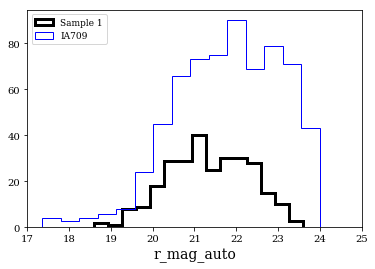

In [16]:
plt.hist(sample_correctz['r_MAG_AUTO'],bins=15,histtype='step',linewidth=3,density=False,stacked=True,color='k',label='Sample 1')
plt.hist(sample_IA709_detected['r_MAG_AUTO'],bins=15,histtype='step',linewidth=1,density=False,stacked=True,color='b',label='IA709')

plt.legend(fontsize=9,loc='upper left')
plt.xlim(17,25)
plt.xlabel('r_mag_auto',fontsize=14)
#plt.ylabel('',fontsize=14)
#plt.savefig('mag_hist_new.eps',dpi=300)

In [ ]:
ALPHA_J2000 = fits.Column(name='ALPHA_J2000', array=sample_IA738_detected['ALPHA_J2000'],format='E')
DELTA_J2000 = fits.Column(name='DELTA_J2000', array=sample_IA738_detected['DELTA_J2000'],format='E')
sample_IA738_detected_fits = fits.BinTableHDU.from_columns([ALPHA_J2000,DELTA_J2000])
sample_IA738_detected_fits.writeto('sample_IA738_detected.fits')

In [ ]:
ALPHA_J2000 = fits.Column(name='ALPHA_J2000', array=sample1['ALPHA_J2000'],format='E')
DELTA_J2000 = fits.Column(name='DELTA_J2000', array=sample1['DELTA_J2000'],format='E')
sample_IA738_detected_fits = fits.BinTableHDU.from_columns([ALPHA_J2000,DELTA_J2000])
sample_IA738_detected_fits.writeto('sample1.fits')

(-0.55, 3)

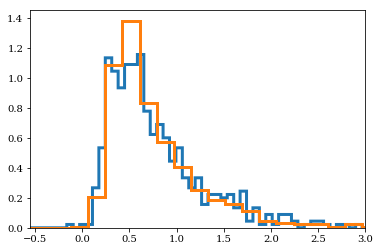

In [17]:
plt.hist(sample_IA709_detected['halflight_radius'],bins=800,histtype='step',linewidth=3,density=True)
plt.hist(sample1['halflight_radius'],bins=300,histtype='step',linewidth=3,density=True)

plt.xlim(-0.55,3)

In [18]:
mask_goodz_709 = sample_IA709_detected['good_z']
sample_goodz = sample_IA709_detected[mask_goodz_709]
len(sample_goodz)

207

(19, 24.1)

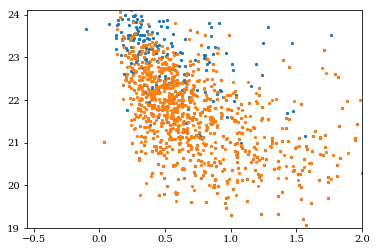

In [19]:
plt.scatter(sample_IA709_detected['halflight_radius'],sample_IA709_detected['r_mag_auto'],s=5)
plt.scatter(sample1['halflight_radius'],sample1['r_mag_auto'],s=5)

plt.xlim(-0.55,2)
plt.ylim(19,24.1)

Text(0,0.5,'logM$_*$ [M$_{\\odot}$]')

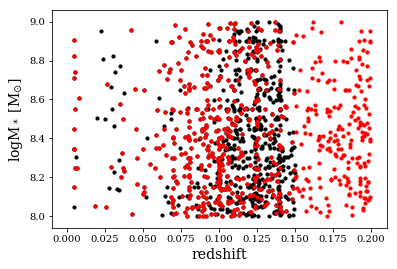

In [15]:
plt.scatter(sample1['redshift'],sample1['MASS_MED'],s=10,c='k')
plt.scatter(sample_IA709_detected['redshift'],sample_IA709_detected['MASS_MED'],s=10,c='r')
plt.xlabel('redshift',fontsize=14)
plt.ylabel('logM$_*$ [M$_{\odot}$]',fontsize=14)
#plt.savefig('mass_z.eps',dpi=300)